In [511]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [574]:
# Constants
g = 9.81
timeyear = 31557600

# Assumed Paramters
Qf = 300 # Flood discharge (m^3/s)
If = 0.03 # Flood intermittency
B = 25 # Channel Width (m)
D = 2/1000 # Grain size (mm/1000)
por_bed = 0.35 # Bed Porosity
kc = 75/1000 # Roughness height (mm/1000)
S = 0.001 # Bed Slope

# Auxiliary Parameters
alr = 8.1 # Manning-Strickler resistance coefficient
alt = 8 # coefficient for sediment transport equation
nt = 1.5 # exponent for sediment transport equation
taustarc = 0.047 # critical Shields stress (dimensionless?)
fis = 1 # fraction of bed shear stress due to skin friction (as opposed to form drag)
Rr = 1.65 # submerged specific gravity of sediment

# Imposed Conditions
Gtf = 210000 # Imposed sediment transport rate from upstream (tons/yr)

# Initial Model River Long Profile Set-Up
L = 10000 # length of river long profile (m)
M = 60 # number of nodes along river long profile
dx = L/M # node spacing
ifault = 30 # node of fault location
detafault = 5 # vertical offset of fault

# Time Steps
dt = 0.001 * timeyear # time steps (yr * timeyear)
Ntoprint = 100 # Number of time steps to each printout
Nprint = 50 # Number of printouts
au = 0.5

In [575]:
# Compute Ambient (arises from flow parameters) and Ultimate Conditions (arises from imposed sediment input)
# Compute Flow Depth, H
H = ((Qf**2) * (kc**(1/3)) / (alr**2) / (B**2) / g / S)**(3/10)
# Compute Dimensionless Bed Shear Stress/Shields Number, taustar
taustar = H * S / Rr / D
# Compute Dimensionless Sediment Flux, qstara
if fis * taustar <= taustarc:
    qstar = 0
else:
    qstar = alt * (fis * taustar - taustarc)**nt
# Compute Volume Sediment Flux Per Unit Width, qt (m^2/s)
qt = ((Rr * g * D)**2) * D * qstara
# Compute Ambient Annual Sediment Transport Rate, Gt (tons/a)
Gt = qt * B * timeyear * (Rr + 1) * If
# Compute Upstream Imposed Volume Sediment Flux Per Unit Width, qtf (m^2/s)
qtf = Gtf / (B * timeyear * (Rr + 1) * If)
# Compute Imposed Dimensionless Sediment Flux, qstarf
qstarf = qtf / (Rr * g * D) ** 0.5 / D
# Compute Imposed Dimensionless Bed Shear Stress, taustarf
taustarf = (taustarc + (qstarf / alt) ** (1 / nt)) / fis
# Compute Ultimate Slope from Imposed Conditions
Sf = ((Rr * D * taustarf) ** (10 / 7)) * ((alr ** 2) * (B ** 2) * g / (Qf ** 2) / (kc ** (1 / 3))) ** (3 / 7)
# Compute Ultimate Flow Depth from Imposed Conditions
Hf = Rr * D * taustarf / Sf

In [576]:
# Computes the inital River Long Profile
def set_initial_profile():
    x = [] # x-location for each node
    eta = [] # bed height at each node
    for i in range(M):
        xi = dx*i
        x.append(xi)
        etai = S*L-S*dx*i
        eta.append(etai)
    for i in range(ifault, M):
        eta[i] = eta[i] - detafault
    time = 0
    return x, eta, time

In [577]:
def find_slope_and_load():
    Sl = []
    qtx = []
    Sl.append((eta[0] - eta[1]) / dx)
    for i in range(1, M-1):
        Sli = (eta[i-1] - eta[i+1]) / (2 * dx)
        Sl.append(Sli)
    Sl.append((eta[M-2] - eta[M-1]) / dx)
    for i in range(M):
        Hx = ((Qf**2) * (kc**(1/3)) / (alr**2) / (B**2) / g / Sl[i])**(3/10)
        taux = Hx * Sl[i] / Rr / D
        if fis * taux <= tausc:
            qstarx = 0
        else:
            qstarx = alt * (fis * taux - tausc) ** nt
        qti = ((Rr * g * D) ** 0.5) * D * qstarx
        qtx.append(qti)
    return Sl, qtx

In [578]:
def find_new_eta(time):
    time += dt
    for i in range(M-1):
        if i == 0:
            qtback = qtf
        else:
            qtback = qtx[i-1]
        qtit = qtx[i]
        qtfront = qtx[i+1]
        qtdif = au * (qtback - qtit) + (1 - au) * (qtit - qtfront)
        eta[i] = eta[i] + dt / (1 - por_bed) / dx * qtdif * If
    return time

In [579]:
x, eta, time = set_initial_profile()
eta_array = np.array(eta)

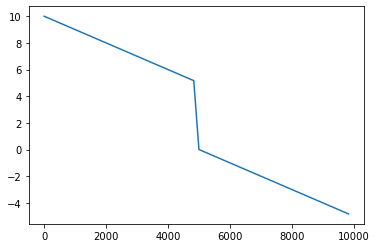

In [580]:
plt.plot(x, eta)

In [581]:
etas = []
etas.append(eta_array)
for j in range(Nprint):
    for w in range(Ntoprint):
        Sl, qtx = find_slope_and_load()
        time = find_new_eta(time)
        eta_array = np.array(eta)
    etas.append(eta_array)
duration = time / timeyear
print(f"Model duration = {duration:.2f} years")

Model duration = 5.00 years


Text(0, 0.5, 'Bed Elevation (m)')

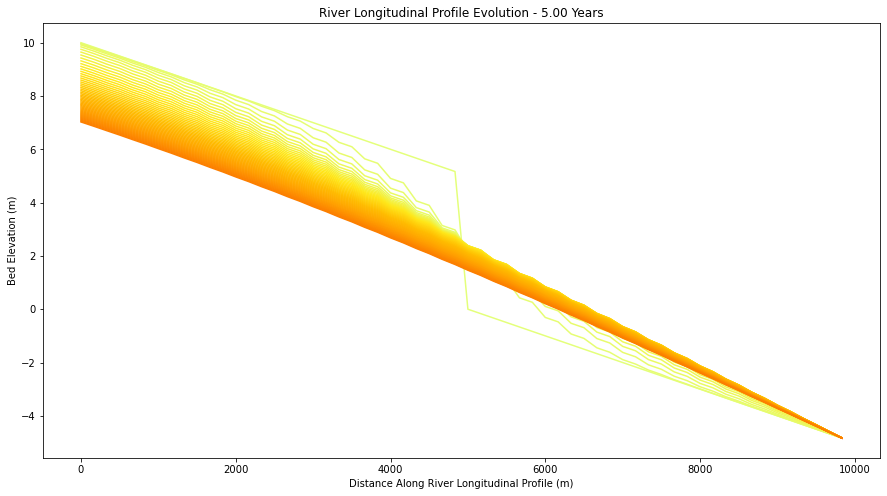

In [582]:
fig, ax = plt.subplots(figsize=(15, 8))

i = -1
for row in etas:
    i += 1
    colors = plt.cm.Wistia(np.linspace(0,1,Nprint+1))
    ax.plot(x, row, color=(colors[i]))

ax.set_title (f"River Longitudinal Profile Evolution - {duration:.2f} Years")
ax.set_xlabel('Distance Along River Longitudinal Profile (m)')
ax.set_ylabel('Bed Elevation (m)')

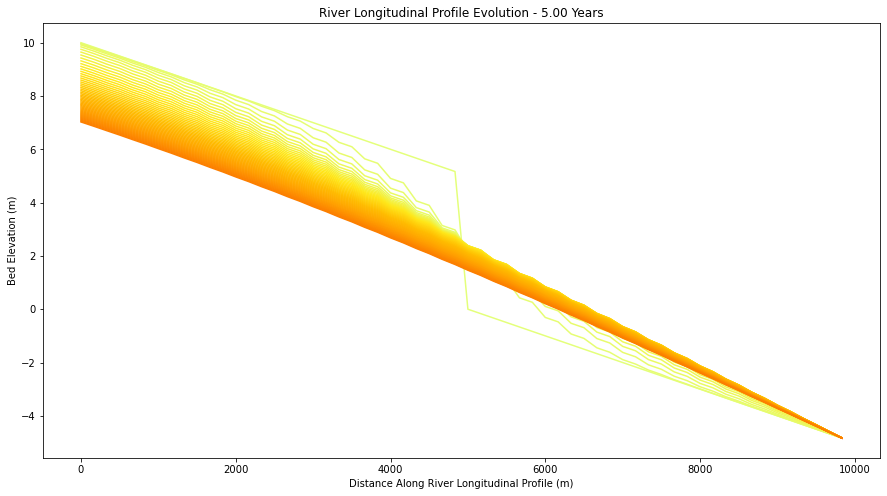

In [586]:
fig, ax = plt.subplots(figsize=(15, 8))
    
ax.set_title (f"River Longitudinal Profile Evolution - {duration:.2f} Years")
ax.set_xlabel('Distance Along River Longitudinal Profile (m)')
ax.set_ylabel('Bed Elevation (m)')

filenames = []
i = -1
for row in etas:
    i += 1
    colors = plt.cm.Wistia(np.linspace(0,1,Nprint+1))
    ax.plot(x, row, color=(colors[i]))
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    plt.savefig(filename)
    #plt.close()

with imageio.get_writer('river_profile.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)